# Estrategia de Trading con Cruce de Medias Móviles

**TEMAS A TRATAR**

Durante este capítulo, abordaremos los siguientes temas clave:

1. **Cálculo de Medias Móviles**

Aprenderemos a calcular medias móviles utilizando ventanas de diferentes tamaños. Comprenderemos cómo elegir las ventanas adecuadas y cómo las medias móviles pueden suavizar la volatilidad de los precios.

2. **Señales de Trading**

Generaremos señales de trading utilizando las medias móviles. Exploraremos cómo detectar los cruces entre la media móvil corta y la media móvil larga como señales de compra o venta.

3. **Evaluación de la Estrategia**

Una parte crucial del trading es evaluar el rendimiento de la estrategia. Calcularemos el capital final obtenido al aplicar esta estrategia a datos históricos de precios de activos.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import mplfinance as mpf
import scipy.stats as stats
import seaborn as sns

import warnings

# Deshabilitar todas las advertencias 
warnings.filterwarnings('ignore')

# Estilo de gráficos
plt.style.use('ggplot')

In [19]:
sp500_df = yf.download(tickers='^GSPC')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


In [20]:
inic_per = '2000-01-01'
fin_per = '2020-12-31'

# inic_per = '2010-01-01'
# fin_per = '2020-12-31'

In [21]:
sp500_per_df = sp500_df.loc[inic_per:fin_per]
sp500_per_df.head(2)

,Adj Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044


Para calcular las médias móviles, vamos a utilizar el método rolling() de pandas, que permite aplicar una función a una ventana de datos. En este caso, la función que vamos a aplicar es la media, que se calcula con el método mean().

In [22]:
# Calcular las medias móviles
short_window = 5
med_window = 50
long_window = 200

sp500_per_df.loc[:, 'SMA5'] = sp500_per_df['Adj Close'].rolling(window=short_window).mean()
sp500_per_df.loc[:, 'SMA50'] = sp500_per_df['Adj Close'].rolling(window=med_window).mean()
sp500_per_df.loc[:, 'SMA200'] = sp500_per_df['Adj Close'].rolling(window=long_window).mean()

In [23]:
sp500_per_df.head(2)

,Adj Close,SMA5,SMA50,SMA200
Date,,,,
2000-01-03,1455.219971,NaN,NaN,NaN
2000-01-04,1399.420044,NaN,NaN,NaN


In [24]:
    
pd.options.plotting.backend = "plotly"

fig = sp500_per_df.loc['2012',:].plot()

fig.add_annotation(
    x="2012-07-27",  # Coordenada x para la anotación
    y=1390,           # Coordenada y para la anotación
    text="EL PRECIO <br> VARÍA MUCHO",  # El texto que deseas agregar
    font=dict(
        size=16,
        color='blue'  # Tamaño de letra personalizado
    ),
    showarrow=True,    # Muestra una flecha apuntando al punto
    arrowhead=2,       # Estilo de la flecha
    arrowwidth=2,      # Grosor de la flecha
    arrowcolor="blue",  # Color de la flecha
    ax=-80,  # Coordenada x final de la flecha
    ay=-50   # Coordenada y final de la flecha
)

fig.add_annotation(
    x="2012-08-31",  # Coordenada x para la anotación
    y=1330,           # Coordenada y para la anotación
    text="A MAYOR VENTANA <br> LA MEDIA VARÍA MÁS DESPACIO",  # El texto que deseas agregar
    font=dict(
        size=16,
        color='purple'  # Tamaño de letra personalizado
    ),
    showarrow=True,    # Muestra una flecha apuntando al punto
    arrowhead=2,       # Estilo de la flecha
    arrowwidth=2,      # Grosor de la flecha
    arrowcolor="purple",  # Color de la flecha
    ax=80,  # Coordenada x final de la flecha
    ay=50   # Coordenada y final de la flecha
)

fig.show()

pd.options.plotting.backend = "matplotlib"


Para este notebook, vamos a usar las medias móviles media (ventana= 50) y larga (ventana= 200) para generar señales de trading:

* Cuando la media móvil corta cruce por encima de la media móvil larga, generaremos una señal de compra. 

* Cuando la media móvil corta cruce por debajo de la media móvil larga, generaremos una señal de venta.

In [25]:
sp500_per_df.head(2)

,Adj Close,SMA5,SMA50,SMA200
Date,,,,
2000-01-03,1455.219971,NaN,NaN,NaN
2000-01-04,1399.420044,NaN,NaN,NaN


In [26]:
# Identificar los puntos de cruce
sp500_per_df.loc[:, 'Signal'] = 0  # Inicializamos la columna de señales

# Generamos las señales donde la media móvil de 50 es mayor que la de 200 ponemos un 1 y si no un 0
# Saltamos las short_window primeras filas [short_window:]
sp500_per_df.loc[:, 'Signal'][short_window:] = np.where(
                                                sp500_per_df.loc[:, 'SMA50'][short_window:] > 
                                                sp500_per_df.loc[:, 'SMA200'][short_window:],
                                                1, 0)

# Al calcular la diferencia entre la señal y la señal del día anterior, obtenemos los puntos de cruce.
# Si la diferencia es 1, es que ha pasado de 0 a 1, por lo que es un cruce alcista
# Si la diferencia es -1, es que ha pasado de 1 a 0, por lo que es un cruce bajista
sp500_per_df.loc[:, 'Position'] = sp500_per_df.loc[:, 'Signal'].diff()

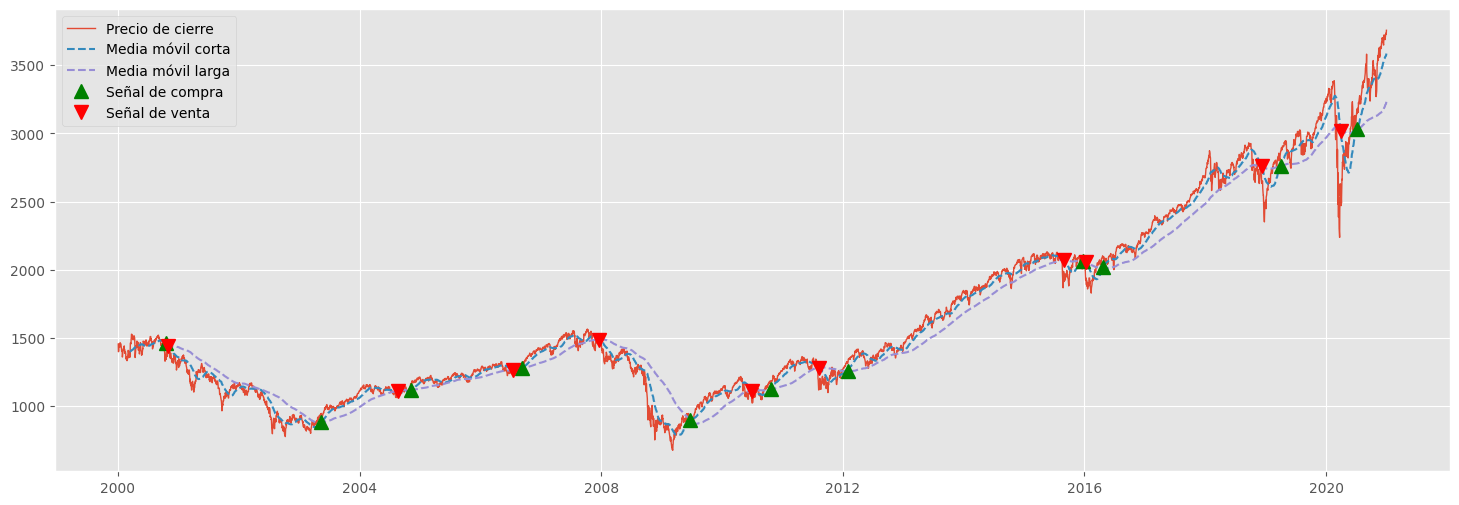

In [27]:
# Graficar los precios y las medias móviles
plt.figure(figsize=(18, 6))
plt.plot(sp500_per_df.index, sp500_per_df['Adj Close'], label='Precio de cierre', linewidth=1)
plt.plot(sp500_per_df.index, sp500_per_df['SMA50'], label='Media móvil corta', linestyle='--')
plt.plot(sp500_per_df.index, sp500_per_df['SMA200'], label='Media móvil larga', linestyle='--')
plt.legend()

# Identificar las señales de compra y venta
buy_signals = sp500_per_df[sp500_per_df['Position'] == 1]
sell_signals = sp500_per_df[sp500_per_df['Position'] == -1]

# Graficar las señales de compra y venta
plt.plot(buy_signals.index, buy_signals['SMA50'], '^', markersize=10, color='g', label='Señal de compra')
plt.plot(sell_signals.index, sell_signals['SMA50'], 'v', markersize=10, color='r', label='Señal de venta')
plt.legend()

plt.show()

In [31]:
# Cuento cuántas posociones de compra (+1) y de venta (-1) hay
sp500_per_df['Position'].value_counts()

Position
 0.0    5262
 1.0      11
-1.0      10
Name: count, dtype: int64

In [32]:
# Calcular los beneficios

estado = 0      # 0 = sin posición, 1 = largo (comprado), -1 = corto (vendido)
buy_price = 0     # Precio de compra
profits = []      # Lista para almacenar los beneficios

for index, row in sp500_per_df.iterrows():
    if row['Position'] == 1:  # Señal de compra
        if estado == 0:
            buy_price = row['Adj Close']
            estado = 1
    elif row['Position'] == -1:  # Señal de venta
        if estado == 1:
            sell_price = row['Adj Close']
            estado = 0
            profit_oper = (sell_price / buy_price) - 1  # Calcula el beneficio
            profits.append(100*profit_oper)

beneficio_df = pd.DataFrame(profits, index=sell_signals.index, columns=['Beneficio'])
beneficio_df.head(2)

,Beneficio
Date,
2000-10-30,1.748850
2004-08-18,16.596756


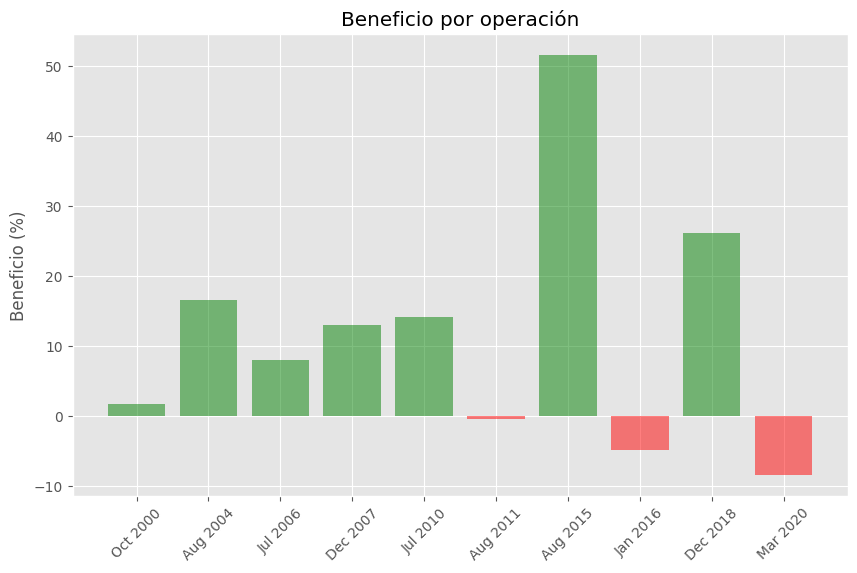

In [35]:
# Graficar los beneficios acumulados
plt.figure(figsize=(10, 6))

# Genero los colores de las barras en función del signo del beneficio
colores = ['green' if beneficio >= 0 else 'red' for beneficio in beneficio_df['Beneficio']]

# Grafico las barras
plt.bar(range(len(beneficio_df.index)), beneficio_df['Beneficio'], color=colores, alpha=0.5)
plt.ylabel('Beneficio (%)')
plt.title('Beneficio por operación')

# Personalizar el eje x para mostrar las fechas
plt.xticks(range(len(beneficio_df.index)), beneficio_df.index.strftime('%b %Y'), rotation=45);